In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops


In [5]:
# Load NSL-KDD
df = pd.read_csv('KDDTrain+.txt', header=None)


In [6]:
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label','difficulty_level'  
]


In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [11]:
df['label'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [9]:
len(columns)

43

In [10]:
df.columns = columns

In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [39]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)


X = df.drop('label',axis=1)
y = df['label']

In [40]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,20
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,15
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,19
3,0,1,24,9,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,21
4,0,1,24,9,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,21


In [41]:

exclude_cols = ['protocol_type', 'service', 'flag']


for col in X.columns:
    if col not in exclude_cols:
        X[col] = X[col].astype(float)


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)


X_test_scaled = scaler.transform(X_test)


In [43]:

knn_graph = kneighbors_graph(X_train_scaled, n_neighbors=10, mode='connectivity', include_self=False)


edge_index_np = knn_graph.nonzero()
edge_index = np.array([edge_index_np[0], edge_index_np[1]])


def to_torch_data(X, y, edge_index):
    x = torch.tensor(X, dtype=torch.float)         
    y = torch.tensor(y.values, dtype=torch.long)   
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, y=y, edge_index=edge_index)


train_data = to_torch_data(X_train_scaled, y_train, edge_index)



knn_graph_test = kneighbors_graph(X_test_scaled, n_neighbors=10, mode='connectivity', include_self=False)
edge_index_np_test = knn_graph_test.nonzero()
edge_index_test = np.array([edge_index_np_test[0], edge_index_np_test[1]])

test_data = to_torch_data(X_test_scaled, y_test, edge_index_test)


In [48]:
class NonNegativeLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        weight_positive = F.relu(self.weight)  
        return F.linear(x, weight_positive, self.bias)


In [49]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class MonotonicGNNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MonotonicGNNConv, self).__init__(aggr='add') 
        self.lin = NonNegativeLinear(in_channels, out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)  
        return self.relu(self.propagate(edge_index, x=x))

    def message(self, x_j):
        return x_j

class MonotonicGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(MonotonicGNN, self).__init__()
        self.conv1 = MonotonicGNNConv(input_dim, hidden_dim)
        self.conv2 = MonotonicGNNConv(hidden_dim, hidden_dim)
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.dropout(self.conv1(x, edge_index))
        x = self.dropout(self.conv2(x, edge_index))
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [50]:
def train_epoch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    return correct / data.num_nodes


### Hyperparameter tuning

In [18]:
import itertools


hidden_dims = [32,64,128]
learning_rates = [ 0.01,0.001]
dropouts = [0.0, 0.3, 0.5]

best_val_acc = 0
best_params = {}

for hidden_dim, lr, dropout in itertools.product(hidden_dims, learning_rates, dropouts):
    print(f"Training with hidden_dim={hidden_dim}, lr={lr}, dropout={dropout}")
    model = MonotonicGNN(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=2, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(200):
        loss = train_epoch(model, train_data, optimizer, criterion)

    val_acc = evaluate(model, test_data)  
    print(f"Validation Accuracy: {val_acc:.4f}\n")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {'hidden_dim': hidden_dim, 'lr': lr, 'dropout': dropout}

print(f"Best Params: {best_params}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Training with hidden_dim=32, lr=0.01, dropout=0.0
Validation Accuracy: 0.9868

Training with hidden_dim=32, lr=0.01, dropout=0.3
Validation Accuracy: 0.9613

Training with hidden_dim=32, lr=0.01, dropout=0.5
Validation Accuracy: 0.9589

Training with hidden_dim=32, lr=0.001, dropout=0.0
Validation Accuracy: 0.8795

Training with hidden_dim=32, lr=0.001, dropout=0.3
Validation Accuracy: 0.8895

Training with hidden_dim=32, lr=0.001, dropout=0.5
Validation Accuracy: 0.8620

Training with hidden_dim=64, lr=0.01, dropout=0.0
Validation Accuracy: 0.9809

Training with hidden_dim=64, lr=0.01, dropout=0.3
Validation Accuracy: 0.9719

Training with hidden_dim=64, lr=0.01, dropout=0.5
Validation Accuracy: 0.9690

Training with hidden_dim=64, lr=0.001, dropout=0.0
Validation Accuracy: 0.9344

Training with hidden_dim=64, lr=0.001, dropout=0.3
Validation Accuracy: 0.9507

Training with hidden_dim=64, lr=0.001, dropout=0.5
Validation Accuracy: 0.8900

Training with hidden_dim=128, lr=0.01, dropout

### Best Hyperparameters selected

In [51]:
best_hidden_dim = 32
best_lr = 0.01
best_dropout = 0.0

model = MonotonicGNN(
    input_dim=X_train.shape[1],
    hidden_dim=best_hidden_dim,
    output_dim=2,
    dropout=best_dropout
)

optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
criterion = torch.nn.CrossEntropyLoss()

epochs = 300
patience = 20  
patience_counter = 0
best_val_acc = 0.0
best_model_state = None

for epoch in range(1, epochs + 1):
    loss = train_epoch(model, train_data, optimizer, criterion)

    if epoch % 20 == 0:
        train_acc = evaluate(model, train_data)
        val_acc = evaluate(model, test_data)
        print(f'Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()  
        else:
            patience_counter += 20

        if patience_counter >= patience:
            print(f"No improvement in validation accuracy for {patience} epochs. Early stopping at epoch {epoch}.")
            break

# Load best model weights after training
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch 020 | Loss: 26.6224 | Train Acc: 0.9265 | Val Acc: 0.9255
Epoch 040 | Loss: 7.2950 | Train Acc: 0.9578 | Val Acc: 0.9555
Epoch 060 | Loss: 3.5131 | Train Acc: 0.9706 | Val Acc: 0.9705
Epoch 080 | Loss: 2.5484 | Train Acc: 0.9727 | Val Acc: 0.9751
Epoch 100 | Loss: 2.0178 | Train Acc: 0.9738 | Val Acc: 0.9760
Epoch 120 | Loss: 1.6684 | Train Acc: 0.9743 | Val Acc: 0.9755
No improvement in validation accuracy for 20 epochs. Early stopping at epoch 120.


In [63]:
print(f'Final Training Accuracy: {train_acc:.4f}')
print(f'Final Validation Accuracy: {val_acc:.4f}')

Final Training Accuracy: 0.9743
Final Validation Accuracy: 0.9755


In [23]:
print("Conv1 weight importance per feature:\n", F.relu(model.conv1.lin.weight.data))

Conv1 weight importance per feature:
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.2636, 1.4655, 0.0000],
        [0.7875, 0.0000, 0.0000,  ..., 1.0142, 0.1786, 1.0289],
        [0.0000, 0.0000, 0.2406,  ..., 0.0175, 0.1292, 0.4966],
        ...,
        [0.0000, 0.0000, 1.9802,  ..., 0.0000, 0.0000, 0.0000],
        [0.5387, 1.2076, 0.0000,  ..., 0.4494, 0.5231, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7937, 0.0000, 0.0000]])


In [25]:
def to_torch_test_data(X, y, n_neighbors=10):
    
    knn_graph = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    edge_index_np = knn_graph.nonzero()
    edge_index = np.array([edge_index_np[0], edge_index_np[1]])
    
 
    x = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y.values if hasattr(y, 'values') else y, dtype=torch.long)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
    
    return Data(x=x, y=y_tensor, edge_index=edge_index_tensor)

In [26]:

df_test_full = pd.read_csv('KDDTest+.txt', header=None)
df_test_full.columns = columns  


for col in categorical_cols:
    le = label_encoders[col]
    df_test_full[col] = le.transform(df_test_full[col])

df_test_full['label'] = df_test_full['label'].apply(lambda x: 0 if x == 'normal' else 1)


X_test_full = df_test_full.drop('label', axis=1)
y_test_full = df_test_full['label']

In [27]:

X_test_full_scaled = scaler.transform(X_test_full)

test_full_data = to_torch_test_data(X_test_full_scaled, y_test_full, n_neighbors=10)


C:\Users\raoro\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\neighbors\base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
C:\Users\raoro\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\neighbors\base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [52]:
final_test_full_acc = evaluate(model, test_full_data)

print(f"\nAccuracy on KDDTest+ dataset: {final_test_full_acc:.4f}")


Accuracy on KDDTest+ dataset: 0.8434


In [78]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


model.eval()

with torch.no_grad():
    out = model(test_full_data)

    preds = out.argmax(dim=1).cpu().numpy() 

true_labels = test_full_data.y.cpu().numpy()


cm = confusion_matrix(true_labels, preds)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")


precision = precision_score(true_labels, preds)
recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Confusion Matrix:
[[9306  405]
 [3125 9708]]
True Positives (TP): 9708
False Positives (FP): 405
False Negatives (FN): 3125
True Negatives (TN): 9306
Precision: 0.9600
Recall:    0.7565
F1 Score:  0.8462


In [81]:
from sklearn.metrics import classification_report


report = classification_report(true_labels, preds, target_names=['Normal', 'Attack'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Normal       0.75      0.96      0.84      9711
      Attack       0.96      0.76      0.85     12833

   micro avg       0.84      0.84      0.84     22544
   macro avg       0.85      0.86      0.84     22544
weighted avg       0.87      0.84      0.84     22544



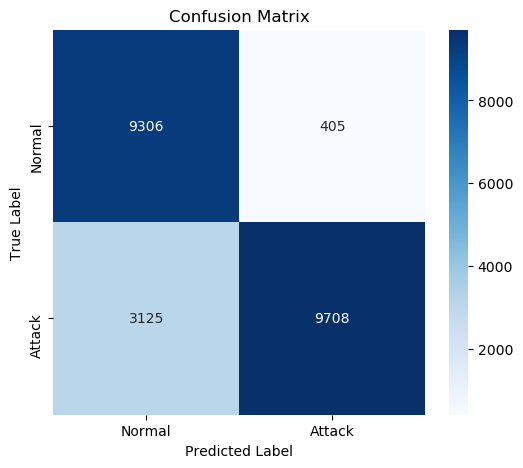

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


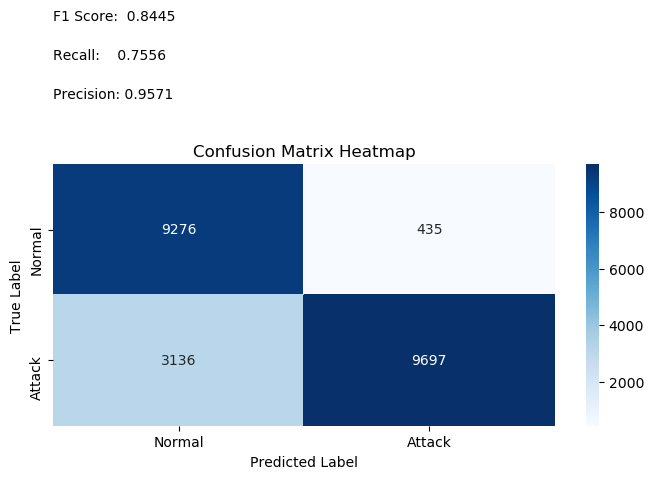

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


cm = confusion_matrix(true_labels, preds)
tn, fp, fn, tp = cm.ravel()


precision = precision_score(true_labels, preds)
recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)


plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')


plt.text(0, -0.5, f'Precision: {precision:.4f}', fontsize=10)
plt.text(0, -0.8, f'Recall:    {recall:.4f}', fontsize=10)
plt.text(0, -1.1, f'F1 Score:  {f1:.4f}', fontsize=10)

plt.tight_layout()
plt.show()


In [28]:
import torch
import numpy as np


weights = model.conv1.lin.weight.detach().cpu().numpy()  


weights = np.maximum(weights, 0)

feature_scores = weights.sum(axis=0)  


In [29]:
top5_indices = np.argsort(feature_scores)[-5:][::-1] 
top5_scores = feature_scores[top5_indices]


In [30]:
top5_feature_names = [X.columns[i] for i in top5_indices]


In [31]:
print("Top 5 Important Features (based on first layer weights):\n")
for name, score in zip(top5_feature_names, top5_scores):
    print(f"{name:<35} Score: {score:.4f}")


Top 5 Important Features (based on first layer weights):

urgent                              Score: 18.2270
serror_rate                         Score: 17.9202
num_file_creations                  Score: 17.2009
dst_host_serror_rate                Score: 16.2439
num_root                            Score: 16.2244


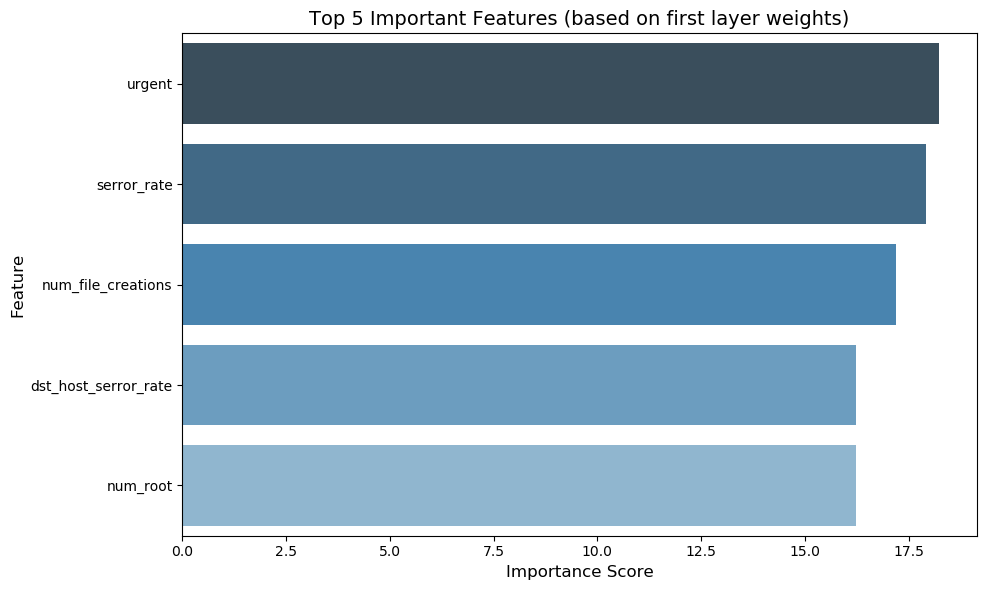

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns


features = [
    'urgent',
    'serror_rate',
    'num_file_creations',
    'dst_host_serror_rate',
    'num_root'
]
scores = [18.2270, 17.9202, 17.2009, 16.2439, 16.2244]


plt.figure(figsize=(10, 6))
sns.barplot(x=scores, y=features, palette='Blues_d')

plt.title('Top 5 Important Features (based on first layer weights)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


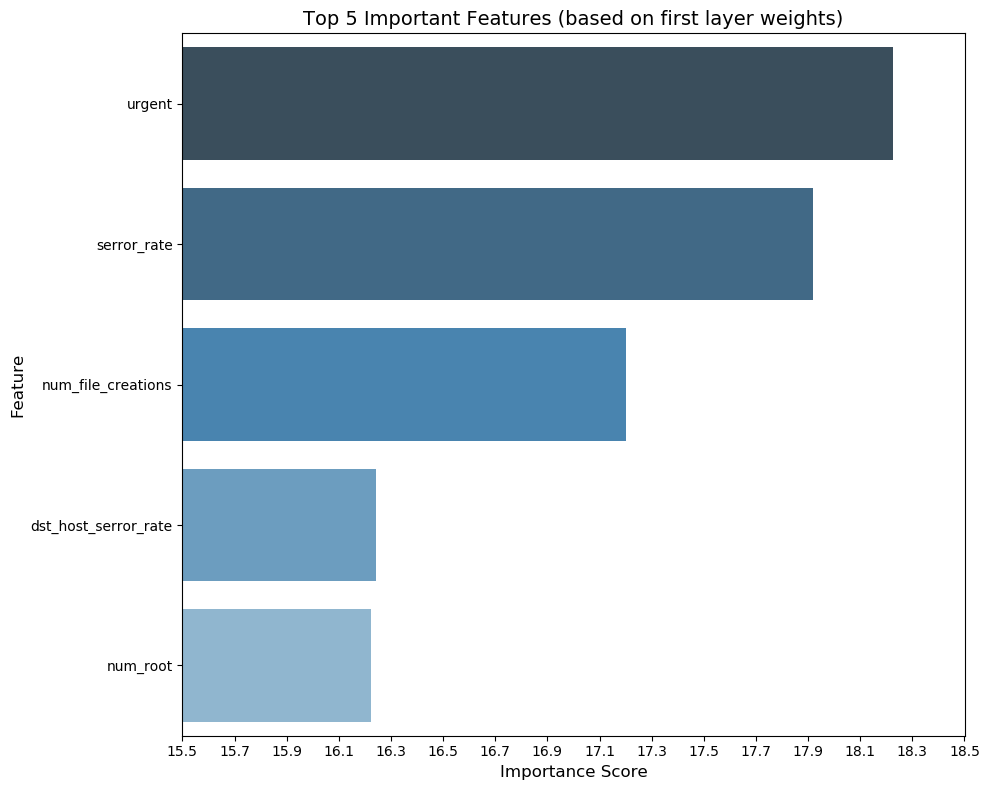

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

features = [
    'urgent',
    'serror_rate',
    'num_file_creations',
    'dst_host_serror_rate',
    'num_root'
]
scores = [18.2270, 17.9202, 17.2009, 16.2439, 16.2244]

plt.figure(figsize=(10, 8))
sns.barplot(x=scores, y=features, palette='Blues_d')

plt.title('Top 5 Important Features (based on first layer weights)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Set custom x-axis limits and tick steps
plt.xlim(15.5, 18.5)  # Add a small margin for visual clarity
plt.xticks(np.arange(15.5, 18.6, 0.2))  # Finer step size: 0.2

plt.tight_layout()
plt.show()


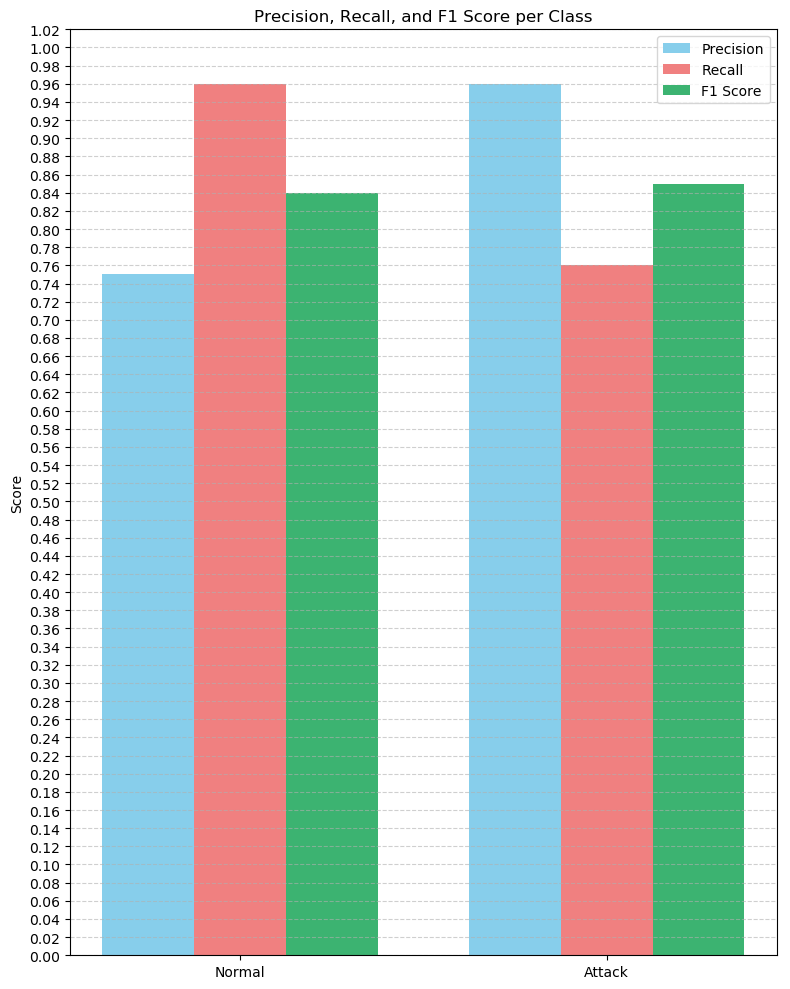

In [84]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Normal', 'Attack']
precision = [0.75, 0.96]
recall = [0.96, 0.76]
f1_score = [0.84, 0.85]

x = np.arange(len(labels))  
width = 0.25  

plt.figure(figsize=(8, 10))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightcoral')
plt.bar(x + width, f1_score, width, label='F1 Score', color='mediumseagreen')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Class')
plt.xticks(x, labels)
plt.yticks(np.arange(0, 1.05, 0.02))  
plt.ylim(0, 1.02)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


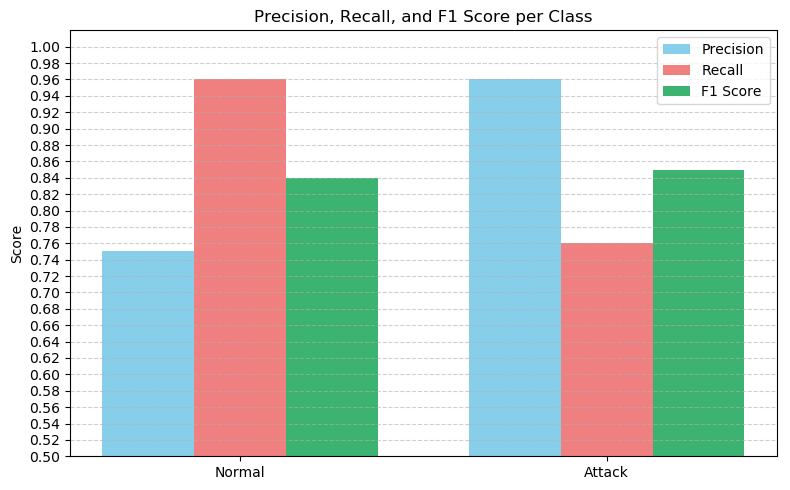

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
labels = ['Normal', 'Attack']
precision = [0.75, 0.96]
recall = [0.96, 0.76]
f1_score = [0.84, 0.85]

x = np.arange(len(labels))  
width = 0.25  

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightcoral')
plt.bar(x + width, f1_score, width, label='F1 Score', color='mediumseagreen')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Class')
plt.xticks(x, labels)
plt.yticks(np.arange(0.5, 1.02, 0.02))  
plt.ylim(0.5, 1.02)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


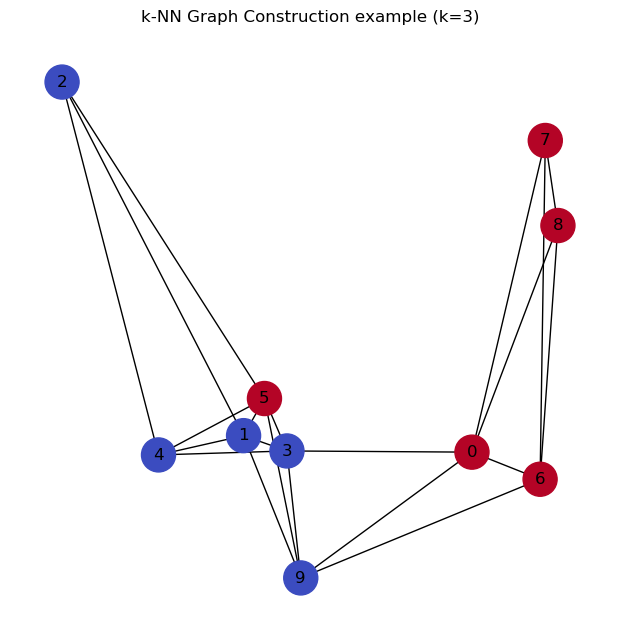

In [94]:
from sklearn.datasets import make_classification
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Sample data with fixed redundancy
X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

# Create k-NN graph
A = kneighbors_graph(X, n_neighbors=3, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_matrix(A)

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos={i: X[i] for i in range(len(X))}, node_color=y, with_labels=True,
        node_size=600, cmap=plt.cm.coolwarm)
plt.title("k-NN Graph Construction example (k=3)")
plt.show()
